# General Graphs and Tables
This notebook contains coe to generate the graphs that have to do with general factors such as populations growth etc.

In [1]:
# Load in packages and data
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from typing import Tuple, List, Dict, Optional

from pathlib import Path

cwd = Path.cwd()

ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')
ll_df_aarhus = pd.read_csv(cwd / 'll_data' / 'll_aarhus.csv')
ll_df_odense = pd.read_csv(cwd / 'll_data' / 'll_odense.csv')

df_list = [ll_df_cph, ll_df_aarhus, ll_df_odense]
county_names = ['københavn', 'århus', 'odense']

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_5374/3333189222.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')


# Summary statistics

In [2]:
def analyze_population_demographics(df_list, county_names):
    """
    Analyze population demographics over time including:
    - Population size
    - Sex ratio
    - Average age by sex
    """
    # Combine all dataframes
    for df, county in zip(df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    combined_df = pd.concat(df_list, ignore_index=True)
    
    # Initialize results dictionary
    results = {
        'total': {},
        'counties': {county: {} for county in county_names}
    }
    
    # Analyze each year for total population
    for year in sorted(combined_df['event_year'].unique()):
        year_data = combined_df[combined_df['event_year'] == year]
        
        # Total population stats
        results['total'][year] = {
            'population': len(year_data),
            'male_count': len(year_data[year_data['sex'] == 'm']),
            'female_count': len(year_data[year_data['sex'] == 'f']),
            'sex_ratio': len(year_data[year_data['sex'] == 'm']) / len(year_data[year_data['sex'] == 'f']),
            'avg_age_male': year_data[year_data['sex'] == 'm']['age'].mean(),
            'avg_age_female': year_data[year_data['sex'] == 'f']['age'].mean(),
            'avg_age_total': year_data['age'].mean()
        }
        
        # County-specific stats
        for county in county_names:
            county_data = year_data[year_data['event_county'] == county]
            if len(county_data) > 0:
                results['counties'][county][year] = {
                    'population': len(county_data),
                    'male_count': len(county_data[county_data['sex'] == 'm']),
                    'female_count': len(county_data[county_data['sex'] == 'f']),
                    'sex_ratio': len(county_data[county_data['sex'] == 'm']) / len(county_data[county_data['sex'] == 'f']),
                    'avg_age_male': county_data[county_data['sex'] == 'm']['age'].mean(),
                    'avg_age_female': county_data[county_data['sex'] == 'f']['age'].mean(),
                    'avg_age_total': county_data['age'].mean()
                }
    
    return results

def create_demographic_visualizations(results):
    """
    Create visualizations for population demographics
    """
    # Set up the figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Color scheme for consistent visualization
    colors = {'københavn': 'blue', 'århus': 'green', 'odense': 'red', 'Total': 'black'}
    
    # 1. Population Size Over Time
    years = sorted(results['total'].keys())
    
    # Plot total population
    total_pop = [results['total'][year]['population'] for year in years]
    ax1.plot(years, total_pop, color=colors['Total'], label='Total', linewidth=2, marker='o')
    
    # Plot county populations
    for county in results['counties'].keys():
        county_pop = [results['counties'][county][year]['population'] 
                     for year in years if year in results['counties'][county]]
        county_years = [year for year in years if year in results['counties'][county]]
        ax1.plot(county_years, county_pop, color=colors[county], label=county, marker='o')
    
    ax1.set_title('Population Size Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Population')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Sex Ratio Over Time (M/F)
    # Plot total sex ratio
    total_ratio = [results['total'][year]['sex_ratio'] for year in years]
    ax2.plot(years, total_ratio, color=colors['Total'], label='Total', linewidth=2, marker='o')
    
    # Plot county sex ratios
    for county in results['counties'].keys():
        county_ratio = [results['counties'][county][year]['sex_ratio'] 
                       for year in years if year in results['counties'][county]]
        county_years = [year for year in years if year in results['counties'][county]]
        ax2.plot(county_years, county_ratio, color=colors[county], label=county, marker='o')
    
    ax2.set_title('Sex Ratio (Male/Female) Over Time')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Sex Ratio (M/F)')
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)  # Reference line for equal ratio
    ax2.legend()
    ax2.grid(True)
    
    # 3. Average Age Over Time
    # Create separate male and female lines for total and each county
    
    # Plot total average ages
    total_male_age = [results['total'][year]['avg_age_male'] for year in years]
    total_female_age = [results['total'][year]['avg_age_female'] for year in years]
    
    ax3.plot(years, total_male_age, color=colors['Total'], label='Total Male', 
             linewidth=2, marker='o', linestyle='-')
    ax3.plot(years, total_female_age, color=colors['Total'], label='Total Female', 
             linewidth=2, marker='s', linestyle='--')
    
    # Plot county average ages
    for county in results['counties'].keys():
        county_years = [year for year in years if year in results['counties'][county]]
        county_male_age = [results['counties'][county][year]['avg_age_male'] 
                          for year in county_years]
        county_female_age = [results['counties'][county][year]['avg_age_female'] 
                           for year in county_years]
        
        ax3.plot(county_years, county_male_age, color=colors[county], 
                 label=f'{county} Male', marker='o', linestyle='-')
        ax3.plot(county_years, county_female_age, color=colors[county], 
                 label=f'{county} Female', marker='s', linestyle='--')
    
    ax3.set_title('Average Age by Sex Over Time')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Average Age')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True)
    
    plt.tight_layout()
    return fig

def print_demographic_summary(results):
    """
    Print summary statistics for population demographics
    """
    print("=== POPULATION DEMOGRAPHICS SUMMARY ===\n")
    
    # Print total population summary
    print("OVERALL POPULATION")
    print("-" * 50)
    years = sorted(results['total'].keys())
    print("\nYear | Total Pop | Sex Ratio | Avg Age (M) | Avg Age (F)")
    print("-" * 55)
    
    for year in years:
        data = results['total'][year]
        print(f"{year} | {data['population']:^9d} | {data['sex_ratio']:^9.2f} | "
              f"{data['avg_age_male']:^10.1f} | {data['avg_age_female']:^10.1f}")
    
    # Print county-specific summaries
    for county in results['counties'].keys():
        print(f"\n{county.upper()}")
        print("-" * 50)
        print("Year | Population | Sex Ratio | Avg Age (M) | Avg Age (F)")
        print("-" * 55)
        
        for year in years:
            if year in results['counties'][county]:
                data = results['counties'][county][year]
                print(f"{year} | {data['population']:^9d} | {data['sex_ratio']:^9.2f} | "
                      f"{data['avg_age_male']:^10.1f} | {data['avg_age_female']:^10.1f}")

=== POPULATION DEMOGRAPHICS SUMMARY ===

OVERALL POPULATION
--------------------------------------------------

Year | Total Pop | Sex Ratio | Avg Age (M) | Avg Age (F)
-------------------------------------------------------
1787 |  195605   |   1.01    |    28.9    |    29.5   
1801 |  216379   |   1.00    |    29.2    |    29.9   
1834 |  189218   |   0.97    |    27.8    |    28.9   
1840 |  287473   |   0.95    |    27.7    |    29.3   
1845 |  301618   |   0.97    |    27.7    |    29.4   
1850 |  310568   |   0.94    |    28.1    |    29.5   
1860 |  362334   |   0.97    |    27.9    |    29.3   
1880 |  512462   |   0.93    |    28.1    |    29.7   
1901 |  785688   |   0.92    |    28.0    |    30.1   

KØBENHAVN
--------------------------------------------------
Year | Population | Sex Ratio | Avg Age (M) | Avg Age (F)
-------------------------------------------------------
1787 |  112320   |   1.04    |    29.2    |    29.7   
1801 |  125014   |   1.03    |    29.2    |    30

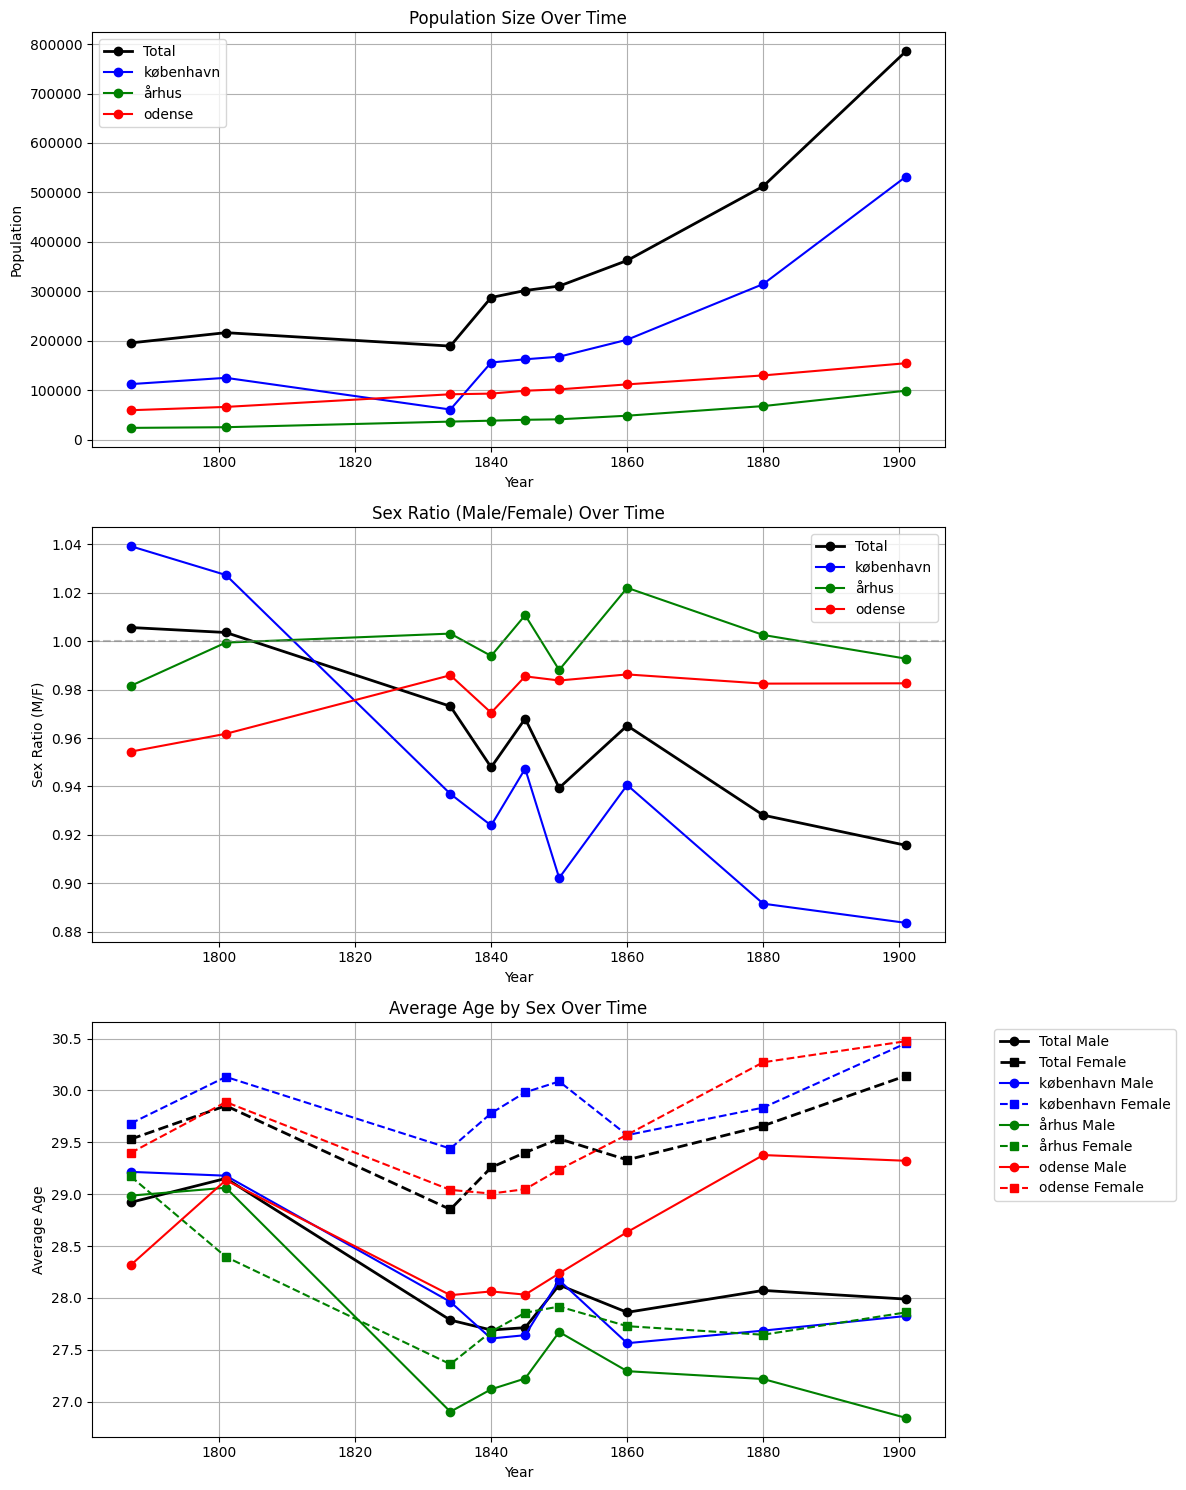

In [3]:
# Run the analysis
demographic_results = analyze_population_demographics(df_list, county_names)

# Print summary statistics
print_demographic_summary(demographic_results)

# Create and display visualizations
fig = create_demographic_visualizations(demographic_results)
plt.show()